In [1]:
import trenchripper as tr

import glob
import h5py

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import skimage as sk

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

plt.style.use('./deaton.mplstyle')

In [2]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list
    
def label_positive_negative(x,ci_max_controls,ci_min_controls,pval=0.05):
    if (x["Value"]>ci_max_controls)&(x["Corrected P-Value"]<pval):
        return "Positive"
    elif (x["Value"]<ci_min_controls)&(x["Corrected P-Value"]<pval):
        return "Negative"
    else:
        return "Neither"
        
def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr
    
def make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,xrange,\
                      extra_highlight_category = None,\
                      control_categories = ['OnlyPlasmid', 'NoTarget'],sigma_vbars=3,figsize=(6,5)):
    ex_df = ss_estimator_df.loc[param]
    if extra_highlight_category != None:
        ex_df_highlighted_category = ex_df[ex_df[extra_highlight_category]]
        ex_df = ex_df[~ex_df[extra_highlight_category]]
        highlighted_sgrna_list_in_category = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid in ex_df_highlighted_category.index.tolist()]
        highlighted_sgrna_list = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid not in ex_df_highlighted_category.index.tolist()]
    
    ex_df_controls = ex_df[ex_df["Category"].isin(control_categories)]
    ex_df_nocontrols = ex_df[~ex_df["Category"].isin(control_categories)]
    ci_max_controls = np.mean(ex_df_controls["Value"]) + 3*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - 3*np.std(ex_df_controls["Value"])
    ex_df_nocontrols["Volcano State"] = ex_df_nocontrols.apply(lambda x: label_positive_negative(x,ci_max_controls,ci_min_controls), axis=1)
    ex_df_highlighted = ex_df_nocontrols.loc[highlighted_sgrna_list]
    print(ex_df_highlighted.sort_values("Value")["Gene"])

    max_log_FDR = np.max(ex_df[r"$-log_{10} FDR$"])

    fig,ax = plt.subplots(1,1,figsize=figsize)
    
    ci_max_controls = np.mean(ex_df_controls["Value"]) + sigma_vbars*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - sigma_vbars*np.std(ex_df_controls["Value"])
    
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Neither")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.03, color="grey",linewidth=0.5, s=80, zorder=-20)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color="tab:green",linewidth=0.5, s=80, zorder=-19)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color="tab:purple",linewidth=0.5, s=80, zorder=-18)
    sns.scatterplot(data=ex_df_controls,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color="tab:orange",linewidth=0.5, s=80, zorder=-15)
    
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color="tab:green",linewidth=1, s=80, zorder=-15)
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color="tab:purple",linewidth=1, s=80, zorder=-14)

    if extra_highlight_category != None:
        ex_df_highlighted_category_nocontrols = ex_df_highlighted_category[~ex_df_highlighted_category["Category"].isin(control_categories)]
        ex_df_highlighted_category_highlighted = ex_df_highlighted_category_nocontrols.loc[highlighted_sgrna_list_in_category]
        sns.scatterplot(data=ex_df_highlighted_category_nocontrols,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color="tab:blue",linewidth=0.5, s=80, zorder=-16)
        sns.scatterplot(data=ex_df_highlighted_category_highlighted,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color="tab:blue",linewidth=1, s=80, zorder=-13)
        
    ax.set_yticks(ticks=[0,1,2,3,max_log_FDR],labels=["0","1","2","3",r"$\geq$" + "{:.2f}".format(max_log_FDR)],fontsize=16,minor=False)
    ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
    ax.set_xlabel(param_label,fontsize=18)
    ax.set_ylabel(r"$-log_{10} FDR$",fontsize=18)
    
    # Manually set the position of the y-axis label
    # The position is specified as (x, y) in axis coordinates (where 0 is the bottom, 1 is the top for y)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
    ax.vlines([ci_min_controls,ci_max_controls],-0.05,max_log_FDR+0.2,linestyle="--",color="black",linewidth=1.5)
    ax.hlines([-np.log10(0.05)],xrange[0],xrange[1],linestyle="--",color="black",linewidth=1.5)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    ax.set_ylim(0,max_log_FDR+0.2)
    ax.set_xlim(xrange[0],xrange[1])
    sns.despine(right=True,top=True)

    if extra_highlight_category != None:
        ex_df_highlighted = pd.concat([ex_df_highlighted,ex_df_highlighted_category_highlighted],axis=0)
        ex_df_highlighted = ex_df_highlighted.sort_values("Value")
        print(ex_df_highlighted["Gene"])
    return fig,ax,ex_df_highlighted

def get_blue_grey_overlay(blue_arr,grey_arr,blue_arr_min,blue_arr_max,grey_arr_min,grey_arr_max):
    
    # Expand dimensions to make them 3D arrays
    image1 = np.expand_dims(blue_arr, axis=-1)
    image2 = np.expand_dims(grey_arr, axis=-1)
    
    # Make image1 green
    img_blue = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint16)
    img_blue[:, :, 2] = image1[:,:,0]
    
    # Make image2 magenta
    img_grey = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint16)
    img_grey[:, :, 0] = image2[:,:,0]
    img_grey[:, :, 1] = image2[:,:,0]
    img_grey[:, :, 2] = image2[:,:,0]
    
    # # Apply contrast to the blue channel
    img_blue[:, :, 2] = sk.exposure.rescale_intensity(np.clip(img_blue[:, :, 2],blue_arr_min,blue_arr_max)).astype('uint16')
    
    # Apply contrast to the magenta channel
    img_grey[:, :, 0] = sk.exposure.rescale_intensity(np.clip(img_grey[:, :, 0],grey_arr_min,grey_arr_max)).astype('uint16')
    img_grey[:, :, 1] = sk.exposure.rescale_intensity(np.clip(img_grey[:, :, 1],grey_arr_min,grey_arr_max)).astype('uint16')
    img_grey[:, :, 2] = sk.exposure.rescale_intensity(np.clip(img_grey[:, :, 2],grey_arr_min,grey_arr_max)).astype('uint16')

    merged_image = np.clip(img_blue.astype(np.uint32) + img_grey.astype(np.uint32), 0, 65535).astype(np.uint16)
    return merged_image

In [3]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:00.823711  58,540 annotations READ: ./ecocyc.gaf 


In [4]:
variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5"

min_n_obervations = 8

ss_estimator_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
ss_estimator_df = ss_estimator_df[ss_estimator_df.apply(lambda x: np.nanmin([x["N Observations"],x["N Observations Proliferating"]]), axis=1)>=min_n_obervations]
ss_estimator_df = ss_estimator_df.loc["Mean (Robust)"]
ss_estimator_df[r"$-log_{10} FDR$"] = -np.log10(ss_estimator_df["Corrected P-Value"])

#hack to fix units
time_df = ss_estimator_df.loc[["Delta time (s)"]]
time_df["Value"] = time_df["Value"]/3600
time_df["Estimator Variance"] = time_df["Estimator Variance"]/(3600**2)
time_df["CI Width"] = time_df["Estimator Variance"]/3600
time_df = time_df.rename(index={"Delta time (s)":"Delta time (hr)"})
ss_estimator_df = pd.concat([time_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Delta time (s)"]))]], axis=0)

growth_df = ss_estimator_df.loc[["Instantaneous Growth Rate: Volume"]]
growth_df["Value"] = growth_df["Value"]/np.log(2)
growth_df["Estimator Variance"] = growth_df["Estimator Variance"]/(np.log(2)**2)
growth_df["CI Width"] = growth_df["Estimator Variance"]/np.log(2)
ss_estimator_df = pd.concat([growth_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Instantaneous Growth Rate: Volume"]))]], axis=0)

sept_df = ss_estimator_df.loc[["Septum Displacement Length Normalized"]]
sept_df["Value"] = sept_df["Value"]*100
sept_df["Estimator Variance"] = sept_df["Estimator Variance"]*(100**2)
sept_df["CI Width"] = sept_df["Estimator Variance"]*100
ss_estimator_df = pd.concat([sept_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Septum Displacement Length Normalized"]))]], axis=0)

var_to_gene_series = ss_estimator_df.reset_index().groupby("oDEPool7_id")["Gene"].first()

## Figure S5A

In [5]:
#style for kymographs
channel_1="mCherry"
channel_2="YFP"
min_intensity_green = 0
max_intensity_green = 15000
min_intensity_magenta = 0
max_intensity_magenta = 50000
green_weight = 1
magenta_weight = 0.8
seg_thickness = 1

t_step = 1
t_i = 59
t_f = 60

yrange = (70,280)

scale_bar_size_um = 10
scale_bar_thickness = 4
scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 200 # Y-position of the scale bar in data units
scalebar_x_position = 120  # X-position of the scale bar in data units
pixel_microns = 0.10595 # Number of microns per pixel for this experiment (can also find in metadata.hdf5)
scale_bar_size_pixels = scale_bar_size_um//pixel_microns
scalebar_on = True

In [6]:
param = "Total Nucleoid Area per Cell Area"
param_label = "NC Ratio"

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

/tmp/ipykernel_29651/1939340179.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_29651/1939340179.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])


/tmp/ipykernel_29651/165064388.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_df_nocontrols["Volcano State"] = ex_df_nocontrols.apply(lambda x: label_positive_negative(x,ci_max_controls,ci_min_controls), axis=1)


oDEPool7_id
4725     rplA
379      rplK
20000     rne
6199     rplQ
23688    dnaA
18951    rpsO
26390    zipA
8976     topA
18016    rpoC
4919     pyrH
Name: Gene, dtype: string


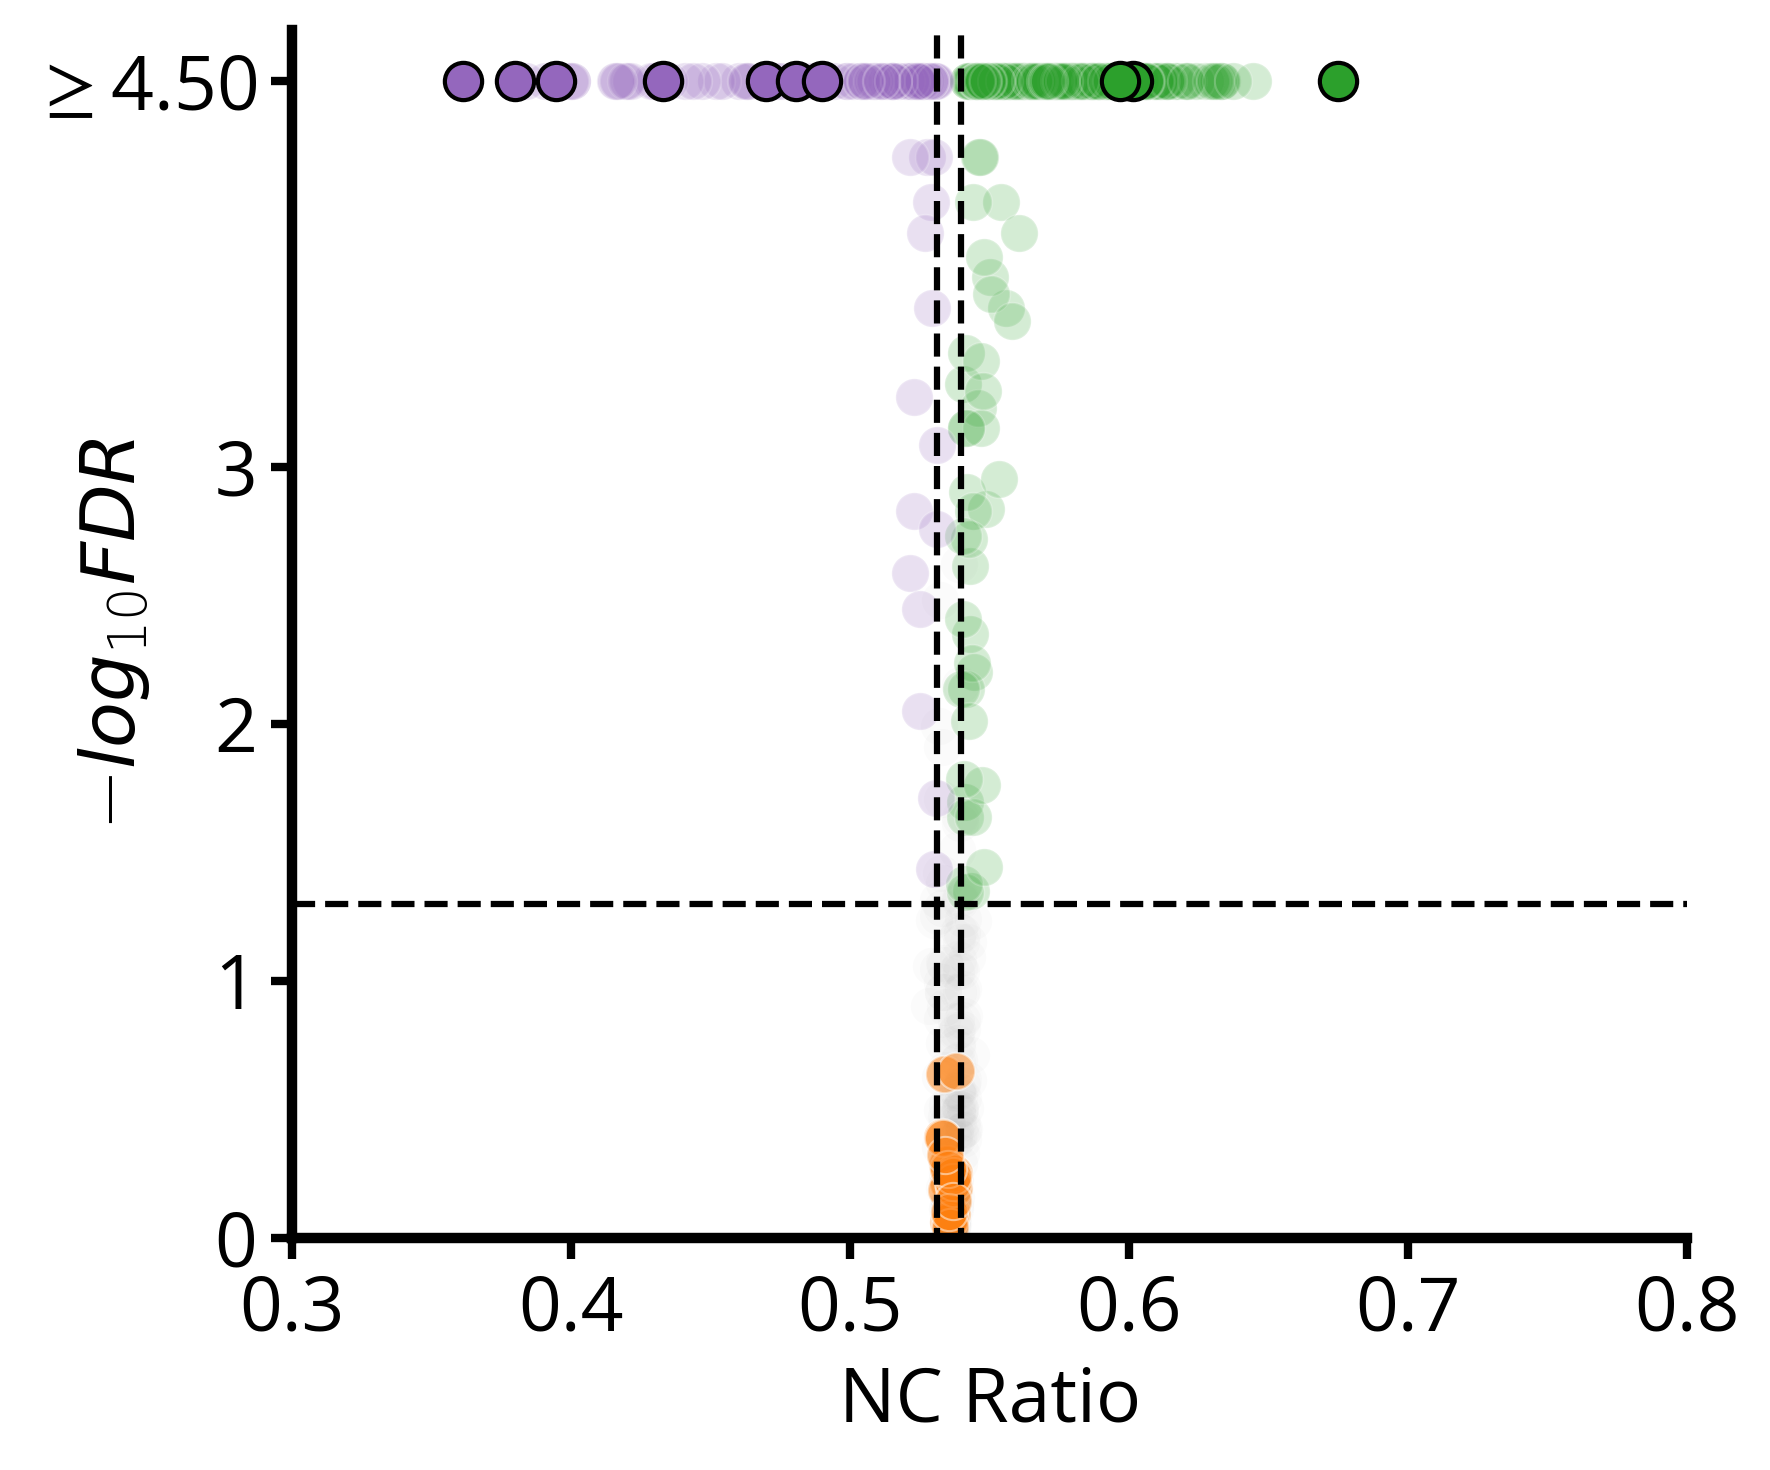

In [7]:
# highlighted_sgrna_list = [23029,2578,4621,9217,20913,13779,903,5357]
highlighted_sgrna_list = [23688,18951,26390,6199,20000,379,4725,18016,4919]
highlighted_sgrna_list = [23688,18951,26390,6199,20000,379,4725,18016,4919,8976]
xrange = (0.3,0.8)

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,xrange)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()
plt.savefig(base_export_path + "/NA_Ratio.png",transparent=True,dpi=500,bbox_inches="tight")

In [8]:
highlighted_sgrna_idx_list = [0,7]
highlighted_trenches_lists = [[4,7,8,9,11,13],[1,2,3,4,6,7]]

tr.writedir(base_export_path + "/NA_Ratio",overwrite=True)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/NA_Ratio/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5B

In [156]:
param = "Number of Nucleoids"
param_label = "N Nucleoids"

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

/tmp/ipykernel_69704/2014836015.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_69704/2014836015.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])


/tmp/ipykernel_69704/165064388.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_df_nocontrols["Volcano State"] = ex_df_nocontrols.apply(lambda x: label_positive_negative(x,ci_max_controls,ci_min_controls), axis=1)


oDEPool7_id
5953     parE
14426    mukB
10425    murC
16778    ftsZ
22136    ftsW
27394    ftsA
26390    zipA
24197    ftsN
27511    minE
Name: Gene, dtype: string


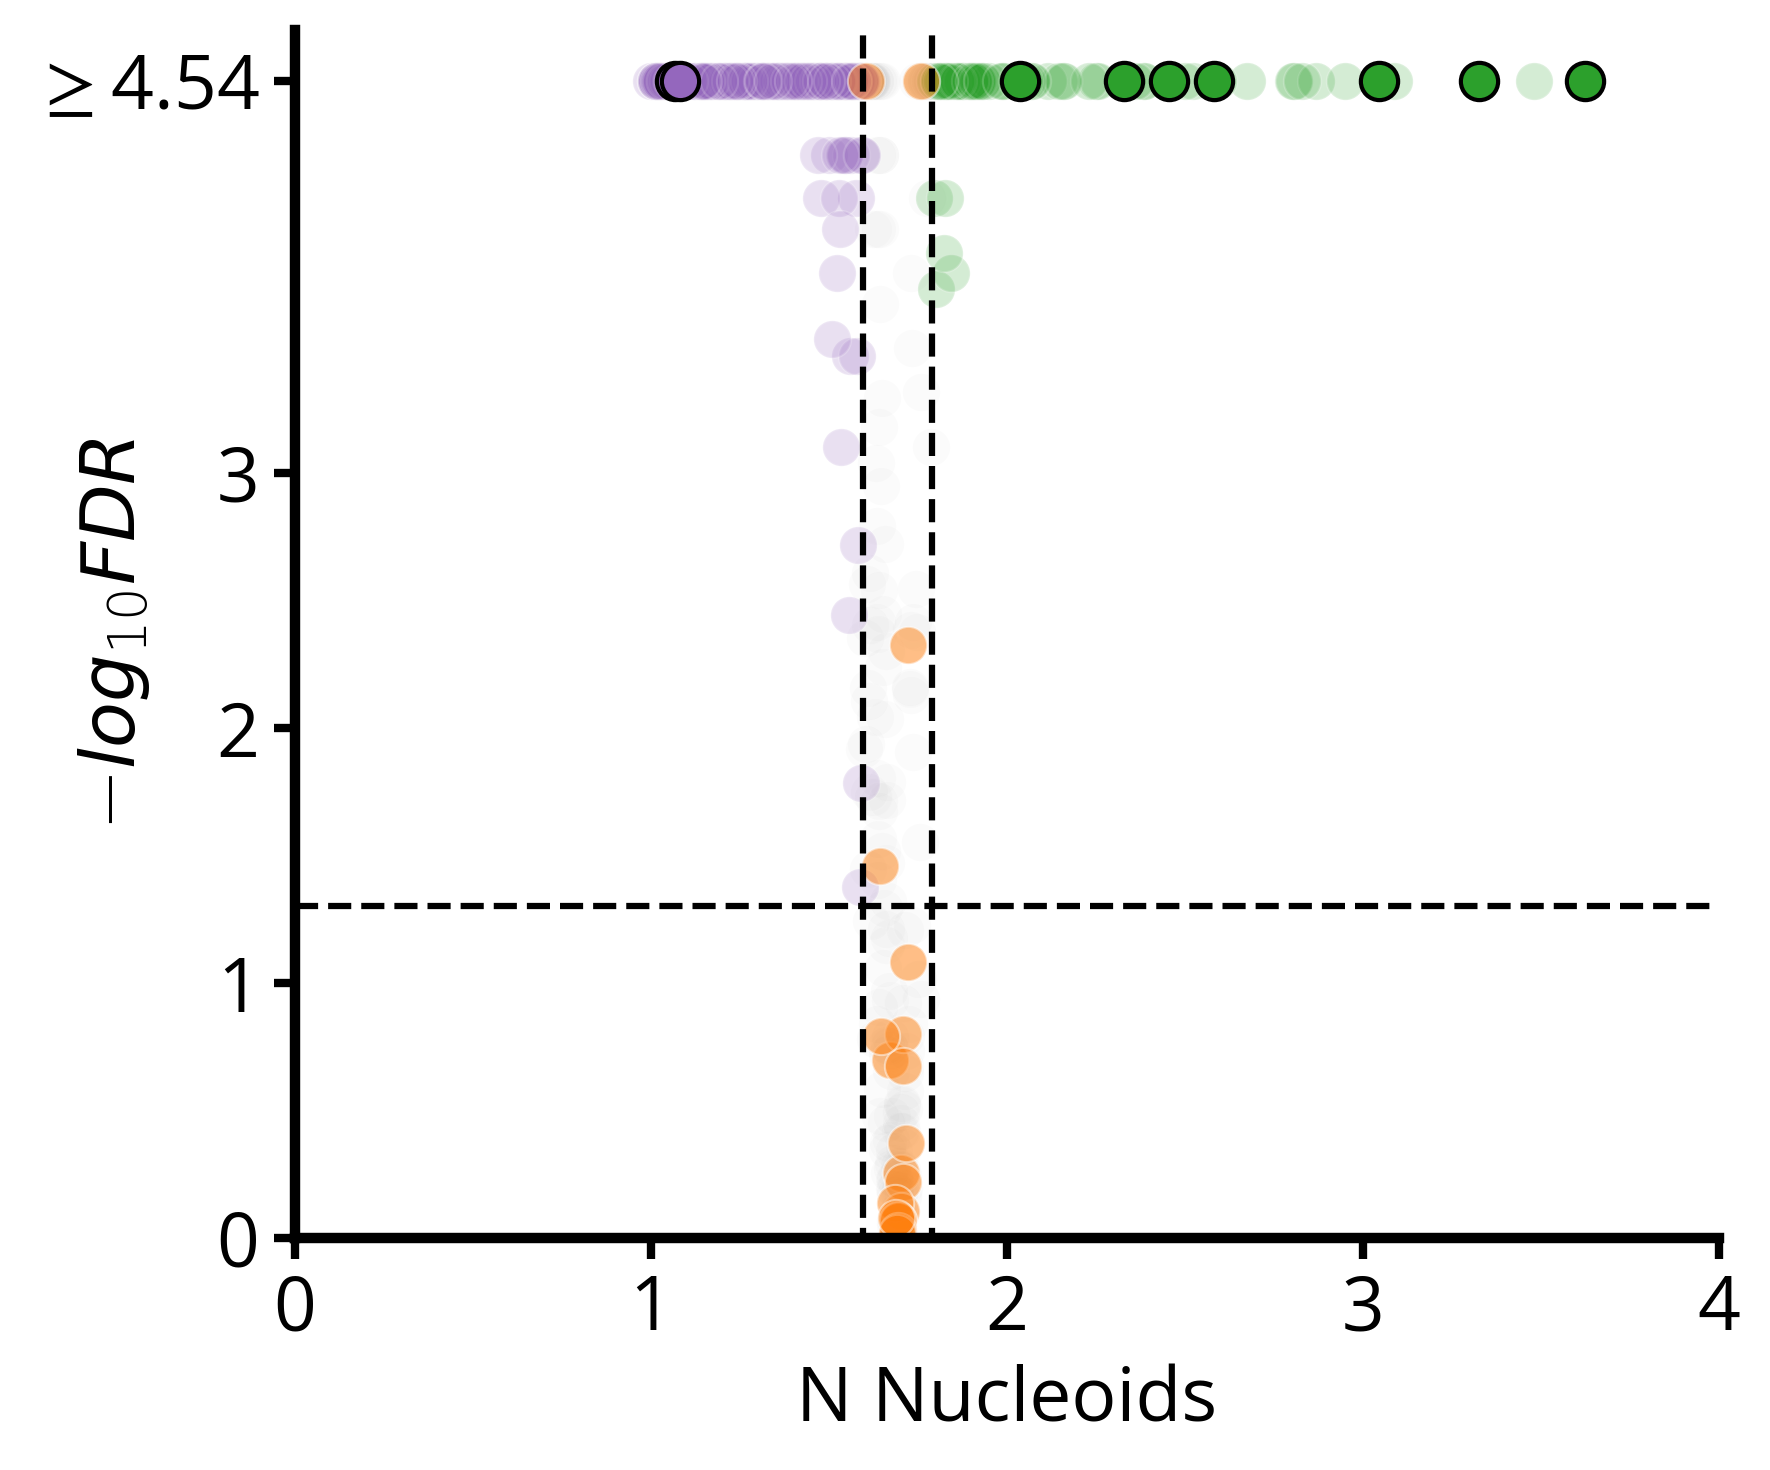

In [157]:
highlighted_sgrna_list = [5953,14426,10425,27394,16778,22136,24197,27511,26390]
xrange = (0,4)

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,xrange)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()
plt.savefig(base_export_path + "/N_Nucleoids.png",transparent=True,dpi=500,bbox_inches="tight")

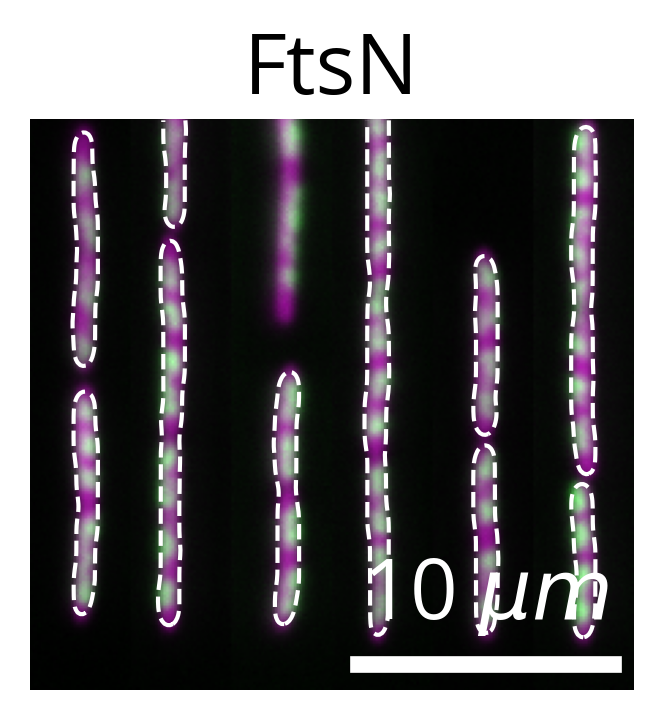

In [158]:
highlighted_sgrna_idx_list = [0,6]
highlighted_trenches_lists = [[0,1,5,6,7,8],[0,2,6,8,10,11]]

tr.writedir(base_export_path + "/N_Nucleoids",overwrite=True)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/N_Nucleoids/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5C

In [159]:
large_subunit_protein = ["rplA","rplI","rplQ","rplS",\
                            "rplY","rpmJ","rpmE","rpmG"]
small_subunit_protein = ["rpsI","rpsO","rpsQ","rpsT","rpsA"]
initiation_factors = ["infA","infB"]
trna_synthetases = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006418")

Searching for tRNA aminoacylation for protein translation


In [160]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Total Nucleoid Area per Cell Area','Instantaneous Growth Rate: Volume']

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

ss_estimators_df = ss_estimators_df.rename(columns={"Total Nucleoid Area per Cell Area":"Nucleoid Area Ratio",\
                                 "Total Nucleoid Area per Cell Area SEM":"Nucleoid Area Ratio SEM",\
                                "Instantaneous Growth Rate: Volume":"Growth Rate (1/hr)",\
                                "Instantaneous Growth Rate: Volume SEM":"Growth Rate (1/hr) SEM"})

ss_estimators_df["Class"] = "None"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(large_subunit_protein),"Class"] = "50S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(small_subunit_protein),"Class"] = "30S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(initiation_factors),"Class"] = "Initiation"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(trna_synthetases),"Class"] = "tRNA Synth"
ss_estimators_df.loc[pd.isnull(ss_estimators_df["Gene"]),"Class"] = "EV"

ribosome_wt_df = ss_estimators_df[(ss_estimators_df["Class"]!="None")&(ss_estimators_df["Class"]!="EV")]
# # ##removing controls
# ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
# ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

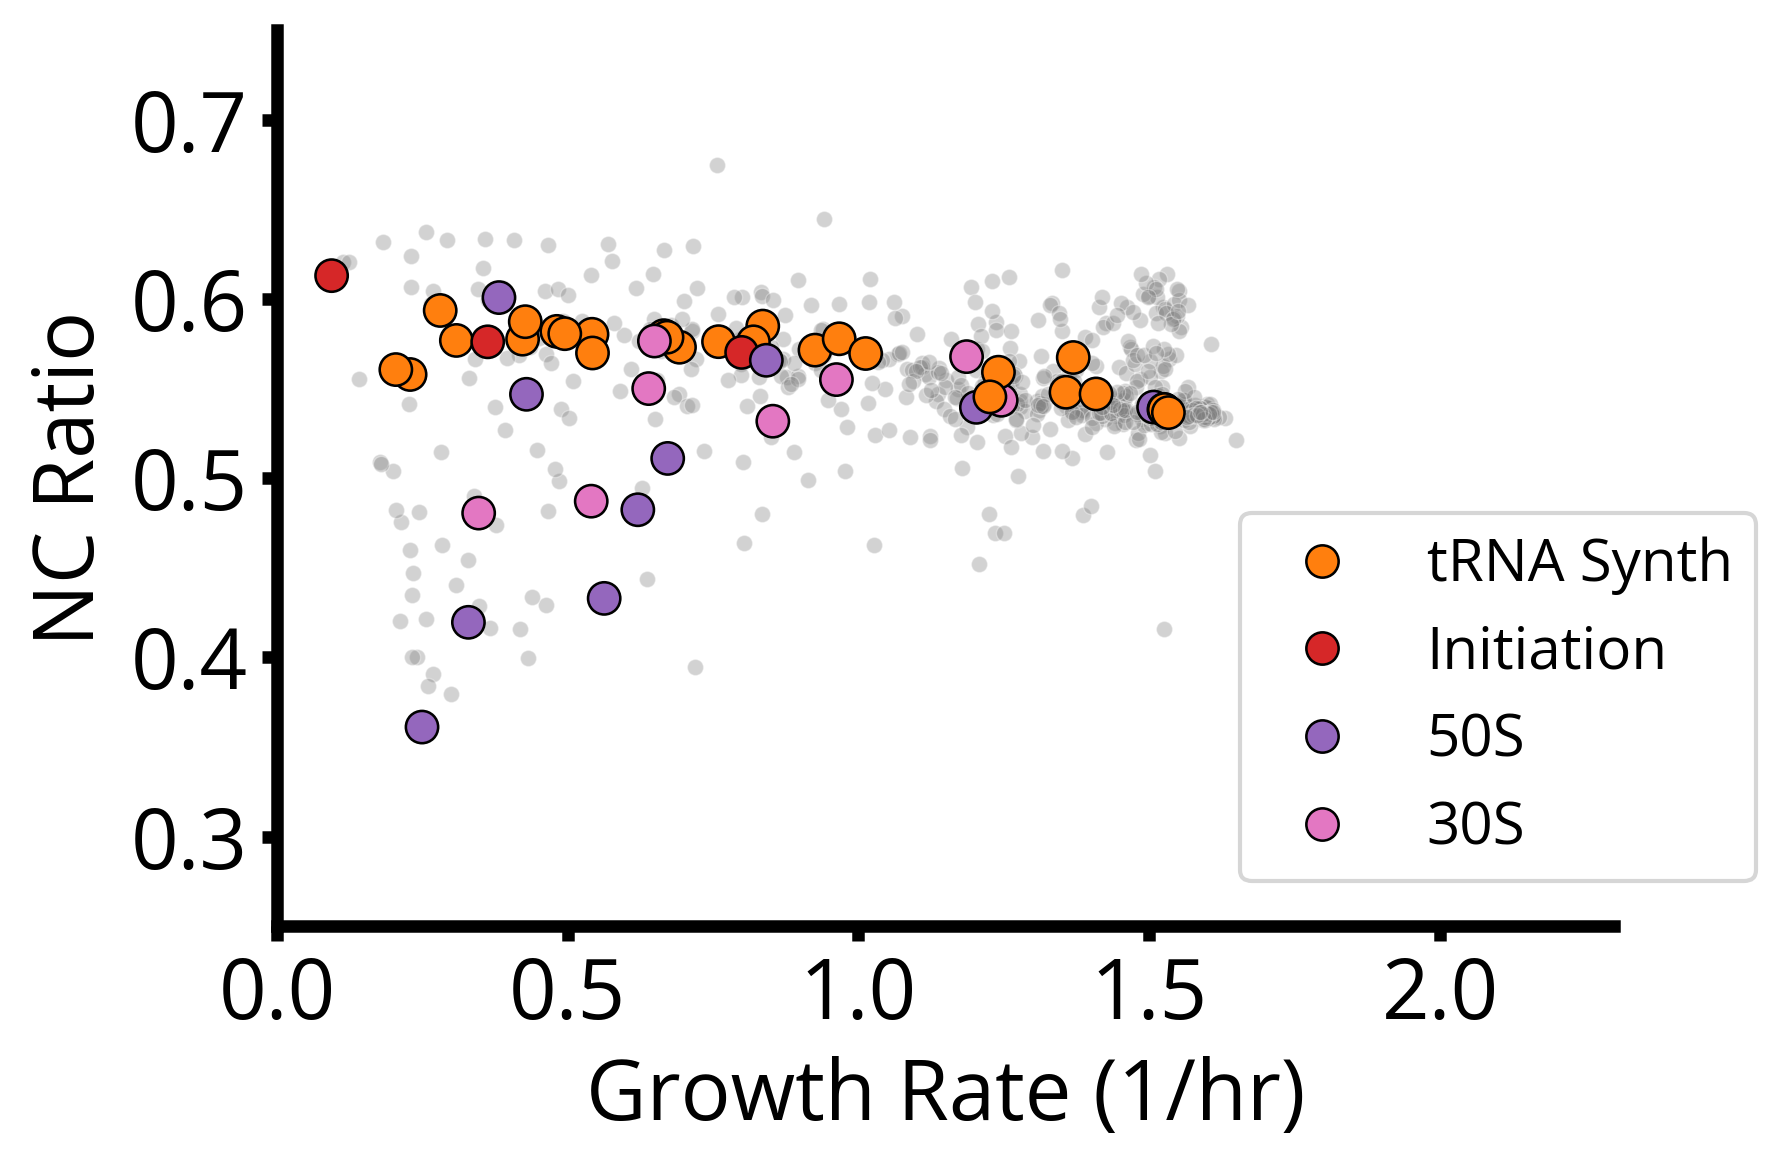

In [161]:
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'30S':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   '50S':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'Initiation':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'Termination':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'tRNA Synth':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   'Ribo Stalk': (0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}

# growth_NA_df = pd.DataFrame(data=[ss_estimators_df.loc['Total Nucleoid Area per Cell Area'].rename(columns={"Total Nucleoid Area per Cell Area":"Nucleoid Area Ratio"})["Nucleoid Area Ratio"],\
#        ss_estimators_df.loc['Instantaneous Growth Rate: Volume'].rename(columns={"Value":"Growth Rate (1/hr)"})["Growth Rate (1/hr)"]]).T

# growth_NA_df_ribo_only = pd.DataFrame(data=[ribosome_wt_df.loc['Total Nucleoid Area per Cell Area'].rename(columns={"Value":"Nucleoid Area Ratio"})["Nucleoid Area Ratio"],\
#        ribosome_wt_df.loc['Instantaneous Growth Rate: Volume'].rename(columns={"Value":"Growth Rate (1/hr)"})["Growth Rate (1/hr)"],\
#                                  ribosome_wt_df.loc['Total Nucleoid Area per Cell Area']['Class']]).T

fig = plt.figure(figsize=(6,4))
plt.ylim(0.25,0.75)
plt.xlim(0,2.3)
plt.ylabel("NC Ratio",fontsize=20)
plt.xlabel("Growth Rate (1/hr)",fontsize=20)
sns.scatterplot(data=ss_estimators_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",s=15,legend=False,color="grey",alpha=0.35)
sns.scatterplot(data=ribosome_wt_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",\
                s=60,hue="Class",palette=strain_pallette,legend=True,edgecolor="black")

# Change the y-axis color and thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# Change the y-axis tick and tick label color
plt.tick_params(axis='x', labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=14,loc=(0.72,0.05))

# plt.legend(fontsize=14,loc=(0.72,0.05),)

sns.despine()
plt.tight_layout()
plt.savefig(base_export_path + "/NAR_Growth_Plot_Translation.png",dpi=500,bbox_inches="tight",
           transparent=True)

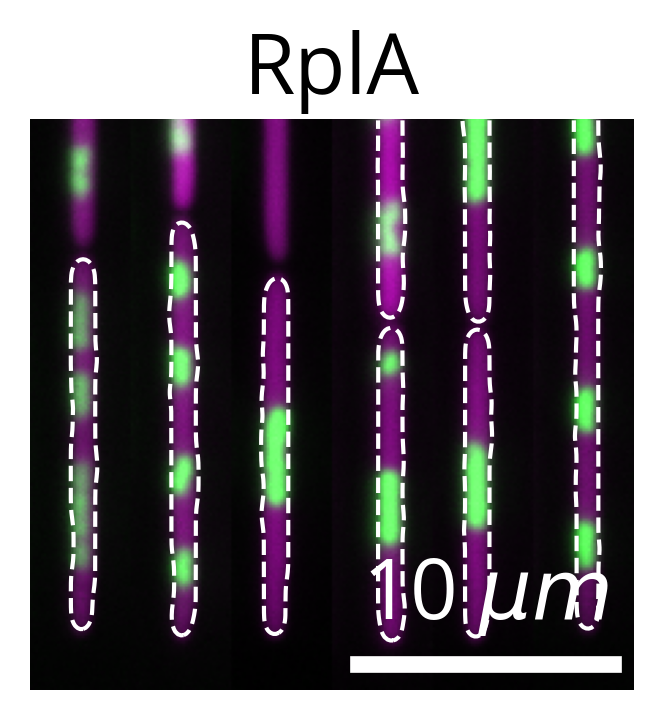

In [162]:
highlighted_df_sgrna_index = list(ribosome_wt_df.index)
highlighted_gene_list = list(ribosome_wt_df['Gene'])
highlighted_sgrna_idx_list = [1,10]
highlighted_trenches_lists = [[1,2,3,4,7,9],[0,3,5,6,7,8]]

tr.writedir(base_export_path + "/NA",overwrite=True)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/NA/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5D

In [163]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Total Nucleoid Area per Cell Area','Instantaneous Growth Rate: Volume']

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-03-25_lDE28_Run_1/Variant_Library"
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE28_Imaging/2024-02-26_lDE28_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

ss_estimators_df = ss_estimators_df.rename(columns={"Total Nucleoid Area per Cell Area":"Nucleoid Area Ratio",\
                                 "Total Nucleoid Area per Cell Area SEM":"Nucleoid Area Ratio SEM",\
                                "Instantaneous Growth Rate: Volume":"Growth Rate (1/hr)",\
                                "Instantaneous Growth Rate: Volume SEM":"Growth Rate (1/hr) SEM"})

ss_estimators_df["Class"] = "None"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(large_subunit_protein),"Class"] = "50S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(small_subunit_protein),"Class"] = "30S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(initiation_factors),"Class"] = "Initiation"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(trna_synthetases),"Class"] = "tRNA Synth"
ss_estimators_df.loc[pd.isnull(ss_estimators_df["Gene"]),"Class"] = "EV"

ribosome_wt_df = ss_estimators_df[(ss_estimators_df["Class"]!="None")&(ss_estimators_df["Class"]!="EV")]

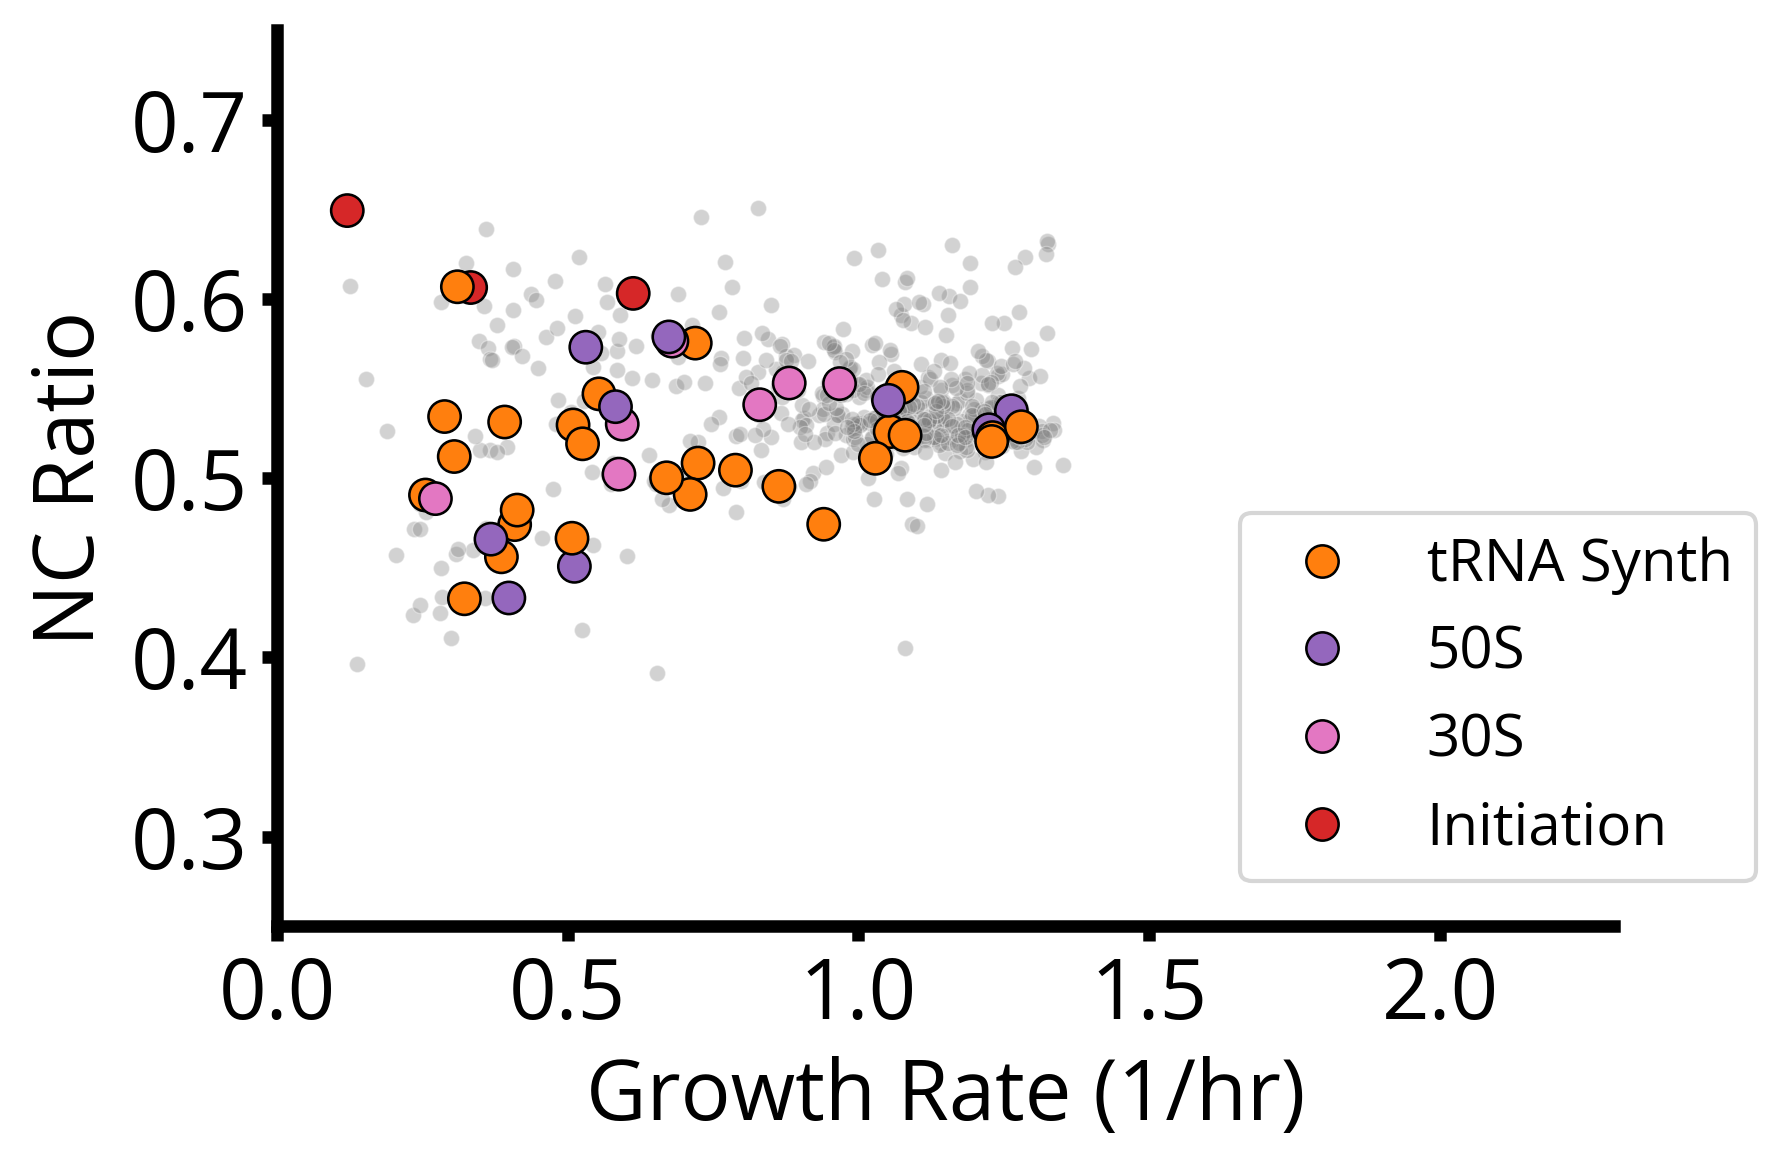

In [164]:
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'30S':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   '50S':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'Initiation':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'Termination':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'tRNA Synth':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   'Ribo Stalk': (0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}

fig = plt.figure(figsize=(6,4))
plt.ylim(0.25,0.75)
plt.xlim(0,2.3)
plt.ylabel("NC Ratio",fontsize=20)
plt.xlabel("Growth Rate (1/hr)",fontsize=20)
sns.scatterplot(data=ss_estimators_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",s=15,legend=False,color="grey",alpha=0.35)
sns.scatterplot(data=ribosome_wt_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",\
                s=60,hue="Class",palette=strain_pallette,legend=True,edgecolor="black")

# Change the y-axis color and thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# Change the y-axis tick and tick label color
plt.tick_params(axis='x', labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=14,loc=(0.72,0.05))

# plt.legend(fontsize=14,loc=(0.72,0.05),)

sns.despine()
plt.tight_layout()
plt.savefig(base_export_path + "/delrelA_NAR_Growth_Plot_Translation.png",dpi=500,bbox_inches="tight",
           transparent=True)

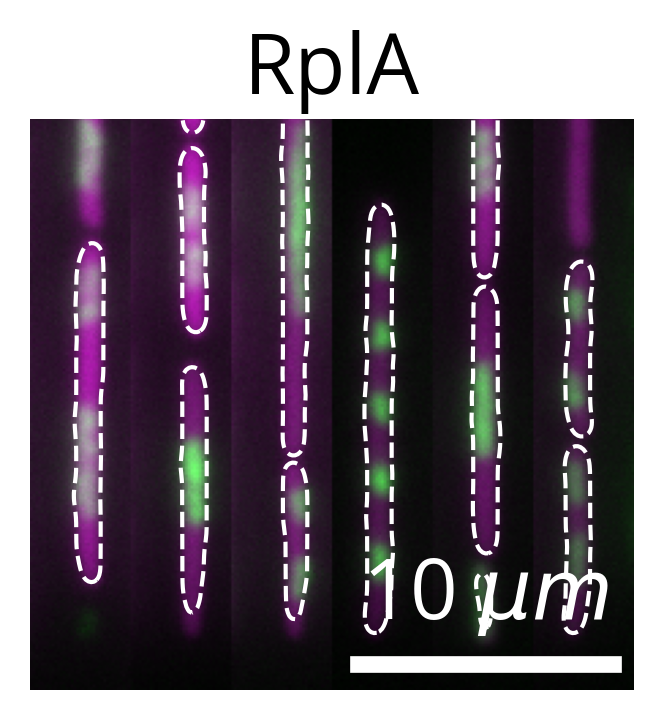

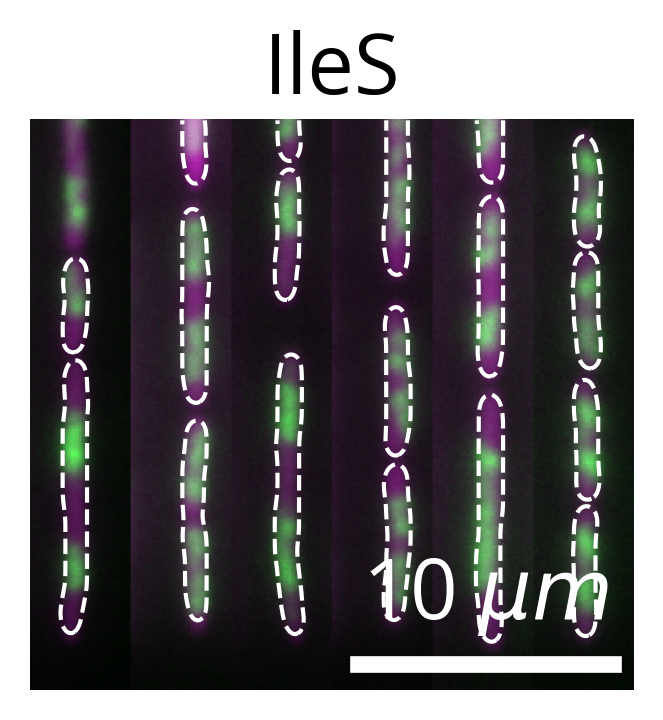

In [165]:
highlighted_df_sgrna_index = list(ribosome_wt_df.index)
highlighted_gene_list = list(ribosome_wt_df['Gene'])
highlighted_sgrna_idx_list = [8,30]
highlighted_trenches_lists = [[0,1,2,3,13,17],[0,1,2,6,8,9]]


tr.writedir(base_export_path + "/delrelA_NA",overwrite=True)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/delrelA_NA/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5E

In [166]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Total Nucleoid Area per Cell Area','Instantaneous Growth Rate: Volume']

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-05-06_lDE30_Run_1/Variant_Library/"
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE30_Imaging/2024-02-26_lDE30_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

ss_estimators_df = ss_estimators_df.rename(columns={"Total Nucleoid Area per Cell Area":"Nucleoid Area Ratio",\
                                 "Total Nucleoid Area per Cell Area SEM":"Nucleoid Area Ratio SEM",\
                                "Instantaneous Growth Rate: Volume":"Growth Rate (1/hr)",\
                                "Instantaneous Growth Rate: Volume SEM":"Growth Rate (1/hr) SEM"})

ss_estimators_df["Class"] = "None"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(large_subunit_protein),"Class"] = "50S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(small_subunit_protein),"Class"] = "30S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(initiation_factors),"Class"] = "Initiation"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(trna_synthetases),"Class"] = "tRNA Synth"
ss_estimators_df.loc[pd.isnull(ss_estimators_df["Gene"]),"Class"] = "EV"

ribosome_wt_df = ss_estimators_df[(ss_estimators_df["Class"]!="None")&(ss_estimators_df["Class"]!="EV")]

In [167]:
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'30S':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   '50S':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'Initiation':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'Termination':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'tRNA Synth':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   'Ribo Stalk': (0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}

fig = plt.figure(figsize=(6,4))
plt.ylim(0.25,0.75)
plt.xlim(0,2.3)
plt.ylabel("NC Ratio",fontsize=20)
plt.xlabel("Growth Rate (1/hr)",fontsize=20)
sns.scatterplot(data=ss_estimators_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",s=15,legend=False,color="grey",alpha=0.35)
sns.scatterplot(data=ribosome_wt_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",\
                s=60,hue="Class",palette=strain_pallette,legend=True,edgecolor="black")

# Change the y-axis color and thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# Change the y-axis tick and tick label color
plt.tick_params(axis='x', labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=14,loc=(0.72,0.05))

# plt.legend(fontsize=14,loc=(0.72,0.05),)

sns.despine()
plt.tight_layout()
plt.savefig(base_export_path + "/ppGpp0_NAR_Growth_Plot_Translation.png",dpi=500,bbox_inches="tight",
           transparent=True)

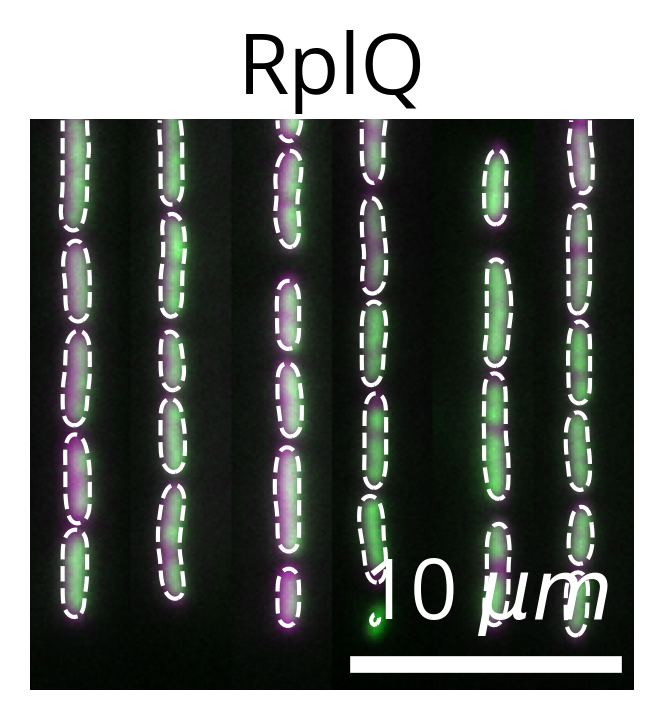

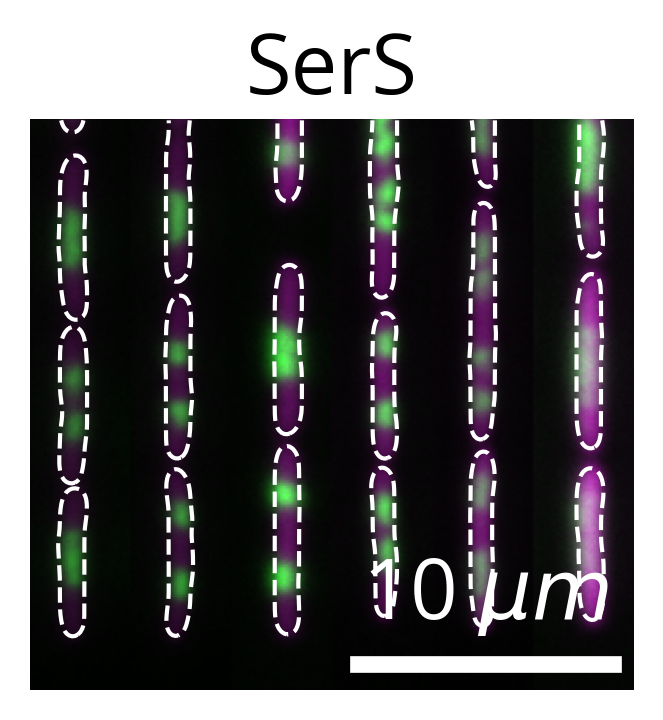

In [168]:
highlighted_df_sgrna_index = list(ribosome_wt_df.index)
highlighted_gene_list = list(ribosome_wt_df['Gene'])
highlighted_sgrna_idx_list = [1,2]
highlighted_trenches_lists = [[0,1,2,3,4,6],[1,2,4,5,7,8]]

tr.writedir(base_export_path + "/ppGpp0_NA",overwrite=True)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/ppGpp0_NA/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5F

In [169]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Total Nucleoid Area per Cell Area','Instantaneous Growth Rate: Volume']

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/Variant_Library"
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

ss_estimators_df = ss_estimators_df.rename(columns={"Total Nucleoid Area per Cell Area":"Nucleoid Area Ratio",\
                                 "Total Nucleoid Area per Cell Area SEM":"Nucleoid Area Ratio SEM",\
                                "Instantaneous Growth Rate: Volume":"Growth Rate (1/hr)",\
                                "Instantaneous Growth Rate: Volume SEM":"Growth Rate (1/hr) SEM"})

ss_estimators_df["Class"] = "None"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(large_subunit_protein),"Class"] = "50S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(small_subunit_protein),"Class"] = "30S"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(initiation_factors),"Class"] = "Initiation"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(trna_synthetases),"Class"] = "tRNA Synth"
ss_estimators_df.loc[pd.isnull(ss_estimators_df["Gene"]),"Class"] = "EV"

ribosome_wt_df = ss_estimators_df[(ss_estimators_df["Class"]!="None")&(ss_estimators_df["Class"]!="EV")]
# # ##removing controls
# ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
# ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

In [170]:
srp = ["ffs","ffh"] #excluding ftsY for possible polar effect
sec = ["secA","secB","yidC","secG","secD","yajC","secF"] # excluding secY, secE for polar effect

ss_estimators_df["Class"] = "None"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(srp),"Class"] = "SRP"
ss_estimators_df.loc[ss_estimators_df["Gene"].isin(sec),"Class"] = "Sec"
ss_estimators_df.loc[pd.isnull(ss_estimators_df["Gene"]),"Class"] = "EV"

sec_srp_wt_df = ss_estimators_df[(ss_estimators_df["Class"]!="None")&(ss_estimators_df["Class"]!="EV")]

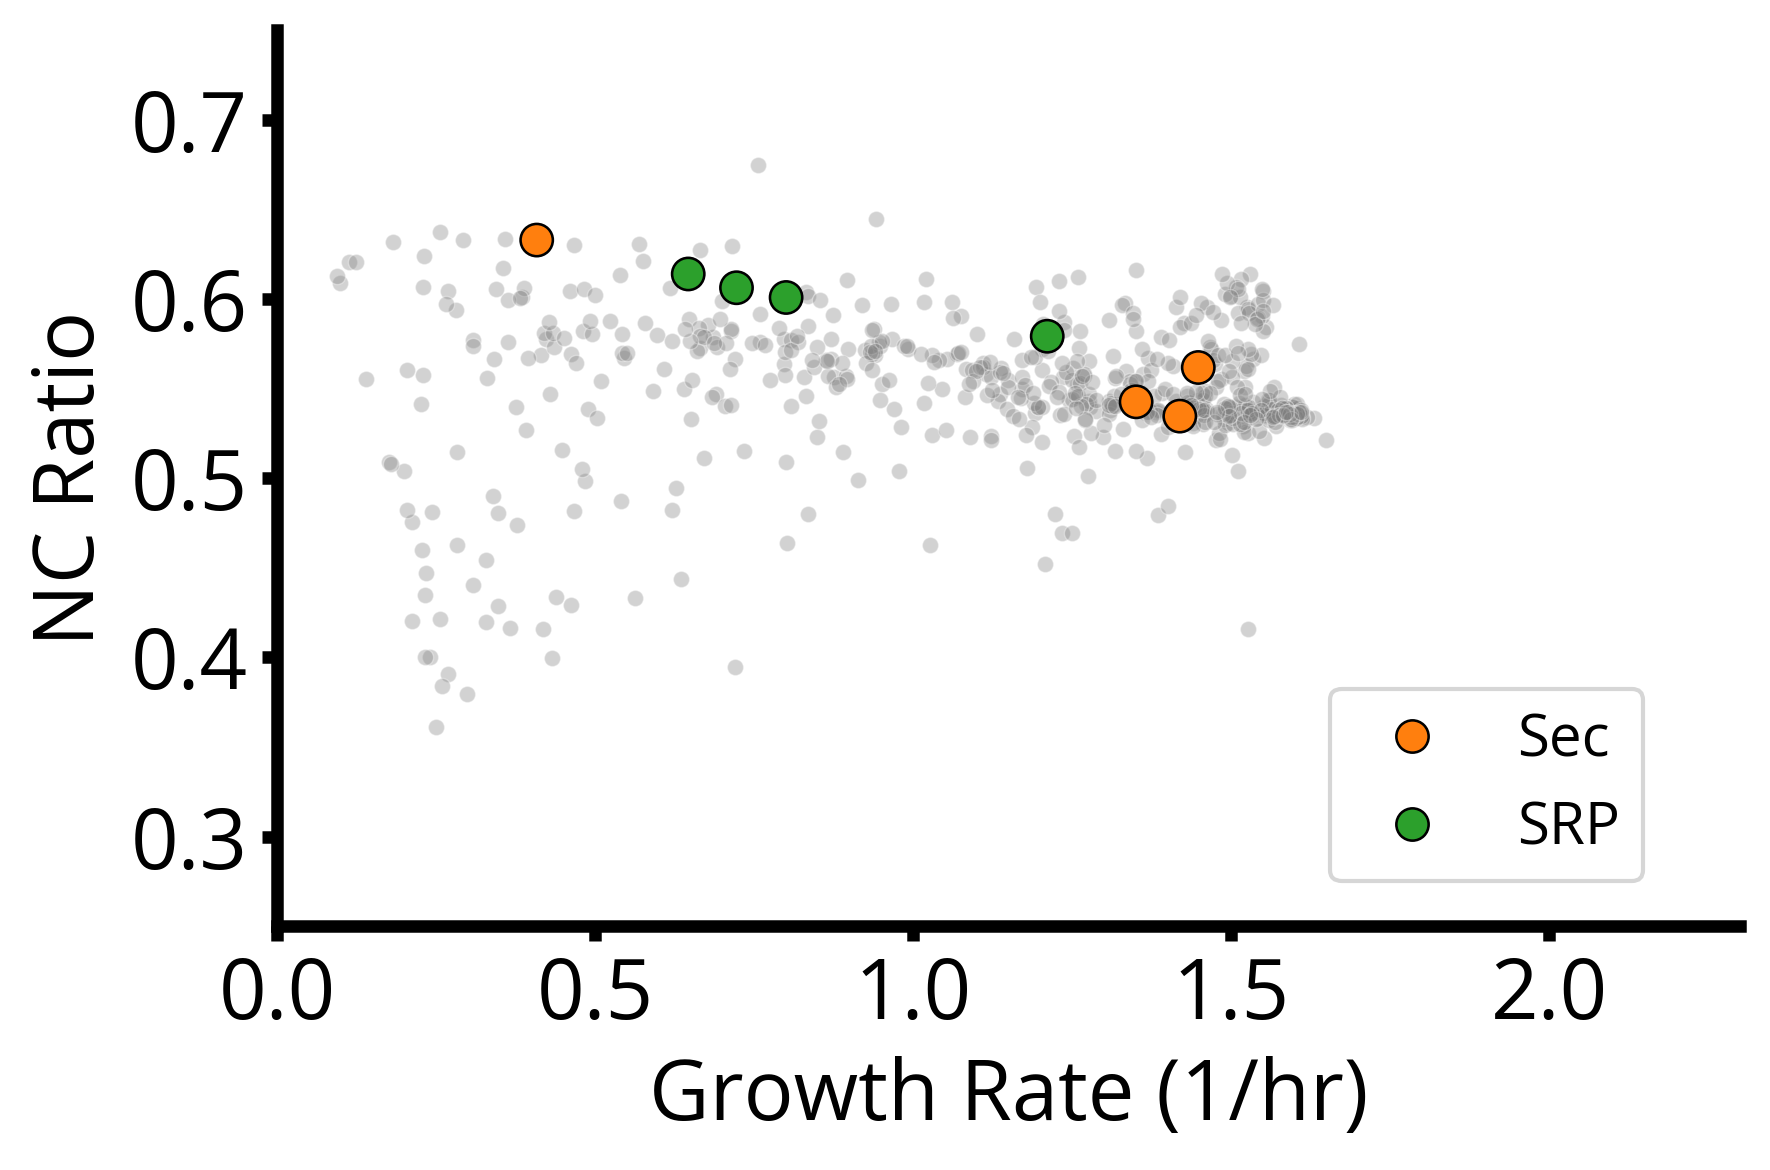

In [171]:
strain_pallette = {'Sec':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'SRP':(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

fig = plt.figure(figsize=(6,4))
plt.ylim(0.25,0.75)
plt.xlim(0,2.3)
plt.ylabel("NC Ratio",fontsize=20)
plt.xlabel("Growth Rate (1/hr)",fontsize=20)
sns.scatterplot(data=ss_estimators_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",s=15,legend=False,color="grey",alpha=0.35)
sns.scatterplot(data=sec_srp_wt_df,x="Growth Rate (1/hr)",y="Nucleoid Area Ratio",\
                s=60,hue="Class",palette=strain_pallette,legend=True,edgecolor="black")

# Change the y-axis color and thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# Change the y-axis tick and tick label color
plt.tick_params(axis='x', labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=14,loc=(0.72,0.05))

# plt.legend(fontsize=14,loc=(0.72,0.05),)

sns.despine()
plt.tight_layout()
plt.savefig(base_export_path + "/NAR_Growth_Plot_Sec_and_SRP.png",dpi=500,bbox_inches="tight",
           transparent=True)

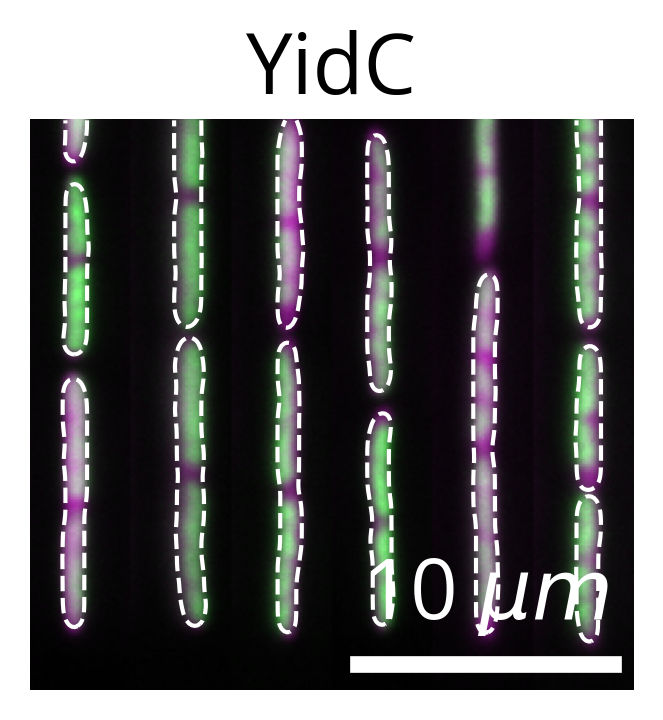

In [172]:
highlighted_df_sgrna_index = list(sec_srp_wt_df.index)
highlighted_gene_list = list(sec_srp_wt_df['Gene'])
highlighted_sgrna_idx_list = [1,3]
highlighted_trenches_lists = [[0,1,2,4,6,7],[1,3,5,6,7,8]]

tr.writedir(base_export_path + "/NA",overwrite=False)
for gene_idx in range(len(highlighted_sgrna_idx_list)):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=2)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=2)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=2)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/NA/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S5G

In [9]:
cell_df_with_nucleoid = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/Imaging/Final_Output_df.pkl")

mean_df = cell_df_with_nucleoid.groupby(["Strain","IPTG_Concentration","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].mean()
median_df = cell_df_with_nucleoid.groupby(["Strain","IPTG_Concentration","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].median()
sem_df = cell_df_with_nucleoid.groupby(["Strain","IPTG_Concentration","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].sem()
mean_of_means_df = mean_df.groupby(["Strain","IPTG_Concentration"]).mean()
mean_of_medians_df = median_df.groupby(["Strain","IPTG_Concentration"]).mean()
sem_of_means_df = mean_df.groupby(["Strain","IPTG_Concentration"]).sem()

In [10]:
strain_name_map = {759:'prfB', 760:'rplA', 761:'rplQ', 763:'fusA', 764:'infA', 773:'WT', 774:'rplL',
       777:'pheT',785:'rpsO'}
# strain_order = ["WT","rpsO","rplQ","rplA","infA","prfB","pheT","fusA","rplL"]
strain_order = ["WT","rpsO","rplQ","rplA"]
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'rpsO':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   'rplQ':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'rplA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'infA':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'prfB':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   'fusA':(0.17254901960784313, 0.6274509803921569, 0.17254901960784313), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}


mean_0IPTG_df = mean_df.loc[(slice(None), 0), :].reset_index()
mean_0IPTG_df = mean_0IPTG_df[mean_0IPTG_df["Strain"].isin(list(strain_name_map.keys()))]
mean_0IPTG_df["Strain"] = mean_0IPTG_df["Strain"].apply(lambda x: strain_name_map[x])
mean_0IPTG_df = mean_0IPTG_df.set_index(["Strain","Run"])
mean_0IPTG_df = mean_0IPTG_df.loc[strain_order]

mean_25IPTG_df = mean_df.loc[(slice(None), 25), :].reset_index()
mean_25IPTG_df = mean_25IPTG_df[mean_25IPTG_df["Strain"].isin(list(strain_name_map.keys()))]
mean_25IPTG_df["Strain"] = mean_25IPTG_df["Strain"].apply(lambda x: strain_name_map[x])
mean_25IPTG_df = mean_25IPTG_df.set_index(["Strain","Run"])
mean_25IPTG_df = mean_25IPTG_df.loc[strain_order]

mean_df_subset = mean_df.loc[(list(strain_name_map.keys()),[0,25]),]
mean_df_subset = mean_df_subset.reset_index()
mean_df_subset["Strain"] = mean_df_subset["Strain"].apply(lambda x: strain_name_map[x])
mean_df_subset["IPTG_Concentration"] = mean_df_subset["IPTG_Concentration"].astype(str)
mean_df_subset = mean_df_subset.set_index(["Strain","IPTG_Concentration","Run"]).sort_index().reset_index().set_index("Strain")
mean_df_subset = mean_df_subset.loc[strain_order]

In [11]:
fig = plt.figure(figsize=(5,4))
hatch_thickness = 2

mpl.rcParams['hatch.linewidth'] = hatch_thickness

ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="major_axis_length",hue="IPTG_Concentration",errorbar=("se",2),
                 order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")
# Apply custom colors to the bars
color_list = [strain_pallette[strain] for strain in strain_order]
custom_colors = color_list + color_list
for i,zipped in enumerate(zip(ax.patches, custom_colors)):
    bar, color = zipped
    bar.set_color("white")
    bar.set_edgecolor(color)
    if i>=len(color_list):
        bar.set_hatch('//')

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.xlabel("")

plt.tick_params(axis='x',rotation=45, labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size
plt.yticks([0,5,10,15])
plt.ylabel(r"Length $ (\mu m) $",fontsize=20)
lgd = plt.legend(fontsize=14) # You can set the fontsize for legend labels here
lgd.remove()
# lgd.set_title('Background', prop={'size': 14})
sns.despine(top=True,right=True)
plt.ylim(0,16)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/Length_Plot_Set_1.png",transparent=True,dpi=500,bbox_inches="tight")

/tmp/ipykernel_29651/407193863.py:6: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="major_axis_length",hue="IPTG_Concentration",errorbar=("se",2),
/tmp/ipykernel_29651/407193863.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="major_axis_length",hue="IPTG_Concentration",errorbar=("se",2),


In [12]:
fig = plt.figure(figsize=(5,4))
hatch_thickness = 2

mpl.rcParams['hatch.linewidth'] = hatch_thickness

### barplot with 2x standard error error bars
# sem_frame = mean_df_subset.groupby(["Strain Name","relA"])["major_axis_length"].sem().to_frame()
# sem_arr = np.array(sem_frame.reset_index().set_index(["relA","Strain Name"]).loc["-"].loc[strain_order].values[:,0].tolist()+\
# sem_frame.reset_index().set_index(["relA","Strain Name"]).loc["+"].loc[strain_order].values[:,0].tolist())

ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="Nucleoid Area Ratio",hue="IPTG_Concentration",errorbar=("se",2),
                 order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")

# Apply custom colors to the bars
color_list = [strain_pallette[strain] for strain in strain_order]
custom_colors = color_list + color_list
for i,zipped in enumerate(zip(ax.patches, custom_colors)):
    bar, color = zipped
    bar.set_color("white")
    bar.set_edgecolor(color)
    if i>=len(color_list):
        bar.set_hatch('//')

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# wt_length = mean_df_subset.loc["WT","0"]["major_axis_length"].mean()
# ax.hlines(wt_length,-0.5,8.7,color="black",linestyles="--",alpha=0.5)

plt.ylim(0,0.55)
plt.tick_params(axis='x',rotation=45, labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size
plt.xlabel("")
plt.ylabel(r"NC Ratio",fontsize=20)
lgd = plt.legend(fontsize=14) # You can set the fontsize for legend labels here
lgd.remove()
# lgd.set_title('Background', prop={'size': 14})
sns.despine(top=True,right=True)
# plt.ylim(0.25,0.35)
# plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/DAPI_NA_Plot_Set_1.png",transparent=True,dpi=500,bbox_inches="tight")

/tmp/ipykernel_29651/2098648590.py:11: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="Nucleoid Area Ratio",hue="IPTG_Concentration",errorbar=("se",2),
/tmp/ipykernel_29651/2098648590.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain",y="Nucleoid Area Ratio",hue="IPTG_Concentration",errorbar=("se",2),


### Select DAPI Images

In [208]:
plt.style.use('default')
scale_bar_size_um = 4

scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 290  # Y-position of the scale bar in data units
scalebar_x_position = 240  # X-position of the scale bar in data units
scalebar_on = False
genename_on = True

strain_name_map = {759:'prfB', 760:'rplA', 761:'rplQ', 763:'fusA', 764:'infA', 773:'WT', 774:'rplL',
       777:'pheT',785:'rpsO'}
strain_name_map_inv = {val:key for key,val in strain_name_map.items()}
pixel_microns = 0.0425
scale_bar_size_pixels = scale_bar_size_um//pixel_microns

In [209]:
selected_gene = "rplA"
iptg_conc = 25
cell_idx = 13
genename_on = True
scalebar_on = False

sel_df = cell_df_with_nucleoid[cell_df_with_nucleoid["Strain"] == strain_name_map_inv[selected_gene]]
sel_df = sel_df[sel_df["IPTG_Concentration"] == iptg_conc]
cell_per_fov = sel_df.groupby("fov").size()
max_cell_fov = cell_per_fov.index[np.argmax(cell_per_fov)]
high_density_sel_df = sel_df[sel_df["fov"]==max_cell_fov]
# sel_cell = sel_df.iloc[cell_idx]
sel_cell = high_density_sel_df.iloc[cell_idx]
centroid_y_pixels = int(sel_cell["centroid_y"]/pixel_microns)
centroid_x_pixels = int(sel_cell["centroid_x"]/pixel_microns)

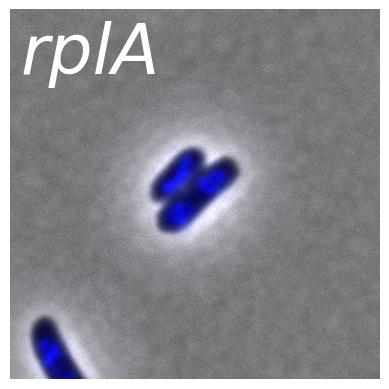

In [210]:
diag_extent = 15

min_intensity_blue = 0
max_intensity_blue = 60000

min_intensity_grey = 0
max_intensity_grey = 30000

output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/Agar_Pads"

diag_extent_pixels = int(diag_extent/pixel_microns)
with h5py.File("/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds/hdf5/hdf5_" + str(sel_cell["File Index"]) + ".hdf5","r") as infile:
    nuc_data = infile["BFP-Penta"][0,centroid_y_pixels-(diag_extent_pixels//2):centroid_y_pixels+(diag_extent_pixels//2),\
                                         centroid_x_pixels-(diag_extent_pixels//2):centroid_x_pixels+(diag_extent_pixels//2)]
    phase_data = infile["MicroManager-Phase"][0,centroid_y_pixels-(diag_extent_pixels//2):centroid_y_pixels+(diag_extent_pixels//2),\
                                         centroid_x_pixels-(diag_extent_pixels//2):centroid_x_pixels+(diag_extent_pixels//2)]
    
merged_image = get_blue_grey_overlay(nuc_data,phase_data,min_intensity_blue,max_intensity_blue,\
                                       min_intensity_grey,max_intensity_grey)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
if genename_on:
    plt.text(10,
            10,
            f"{selected_gene}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=50)
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=10)
    # Add a label next to the scale bar
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+20,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=25)
    
plt.axis('off')
plt.savefig(output_path + "/" + selected_gene + "_" + str(iptg_conc) + "IPTG_" + str(cell_idx) + ".png", dpi=300, bbox_inches='tight')

## Figure S5H

In [10]:
plt.style.use('./deaton.mplstyle')
strain_name_map = {787:('WT','+'), 825:('WT','-'), 747:('tufA','+'), 824:('tufA','-'),
                   814:('rplL','+'), 818:('rplL','-'), 816:('infA','+'),820:('infA','-'),
                   817:('pheT','+'), 821:('pheT','-'), 815:('fusA','+'),819:('fusA','-'),
                   822:('fusA*','+'), 823:('fusA*','-'), 806:(r'$p_{AHL}$-fusA','+'),808:(r'$p_{AHL}$-fusA','-')}

strain_order = ["WT","infA","pheT","fusA",r"$p_{AHL}$-fusA","rplL"]
# excluding fusA*
# Define a custom palette, style consistent with rest of figure
# strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
#                    'tufA':(1.0, 0.4980392156862745, 0.054901960784313725), \
#                    'rplL':(0.7372549019607844, 0.7411764705882353, 0.13333333333333333), \
#                    'infA':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
#                    'pheT':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
#                    'fusA':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902),\
#                    r'$p_{AHL}$-fusA': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),\
#                    'fusA*': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'rpsO':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   'rplQ':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'rplA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'tufA':(1.0, 0.7104873484663576, 0.4549019607843139), \
                   'infA':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'prfB':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   r'$p_{AHL}$-fusA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   'fusA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}

cell_df_with_nucleoid = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/Imaging/Final_Output_df.pkl")

cell_df_with_nucleoid["Strain Name"] = cell_df_with_nucleoid["Strain"].apply(lambda x: strain_name_map[x][0])
cell_df_with_nucleoid["relA"] = cell_df_with_nucleoid["Strain"].apply(lambda x: strain_name_map[x][1])

In [11]:
mean_df = cell_df_with_nucleoid.groupby(["Strain Name","relA","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].mean()
median_df = cell_df_with_nucleoid.groupby(["Strain Name","relA","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].median()
sem_df = cell_df_with_nucleoid.groupby(["Strain Name","relA","Run"])[["area","major_axis_length","GFP-Penta mean_intensity","BFP-Penta mean_intensity",\
                                "Total Nucleoid Area","Avg Nucleoid mean_intensity","Total Nucleoid Intensity","Nucleoid Area Ratio"]].sem()
mean_of_means_df = mean_df.groupby(["Strain Name","relA"]).mean()
mean_of_medians_df = median_df.groupby(["Strain Name","relA"]).mean()
sem_of_means_df = mean_df.groupby(["Strain Name","relA"]).sem()
mean_df_subset = mean_df.loc[strain_order]

/tmp/ipykernel_11614/1948294582.py:6: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="major_axis_length",hue="relA",errorbar=("se",2),
/tmp/ipykernel_11614/1948294582.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="major_axis_length",hue="relA",errorbar=("se",2),


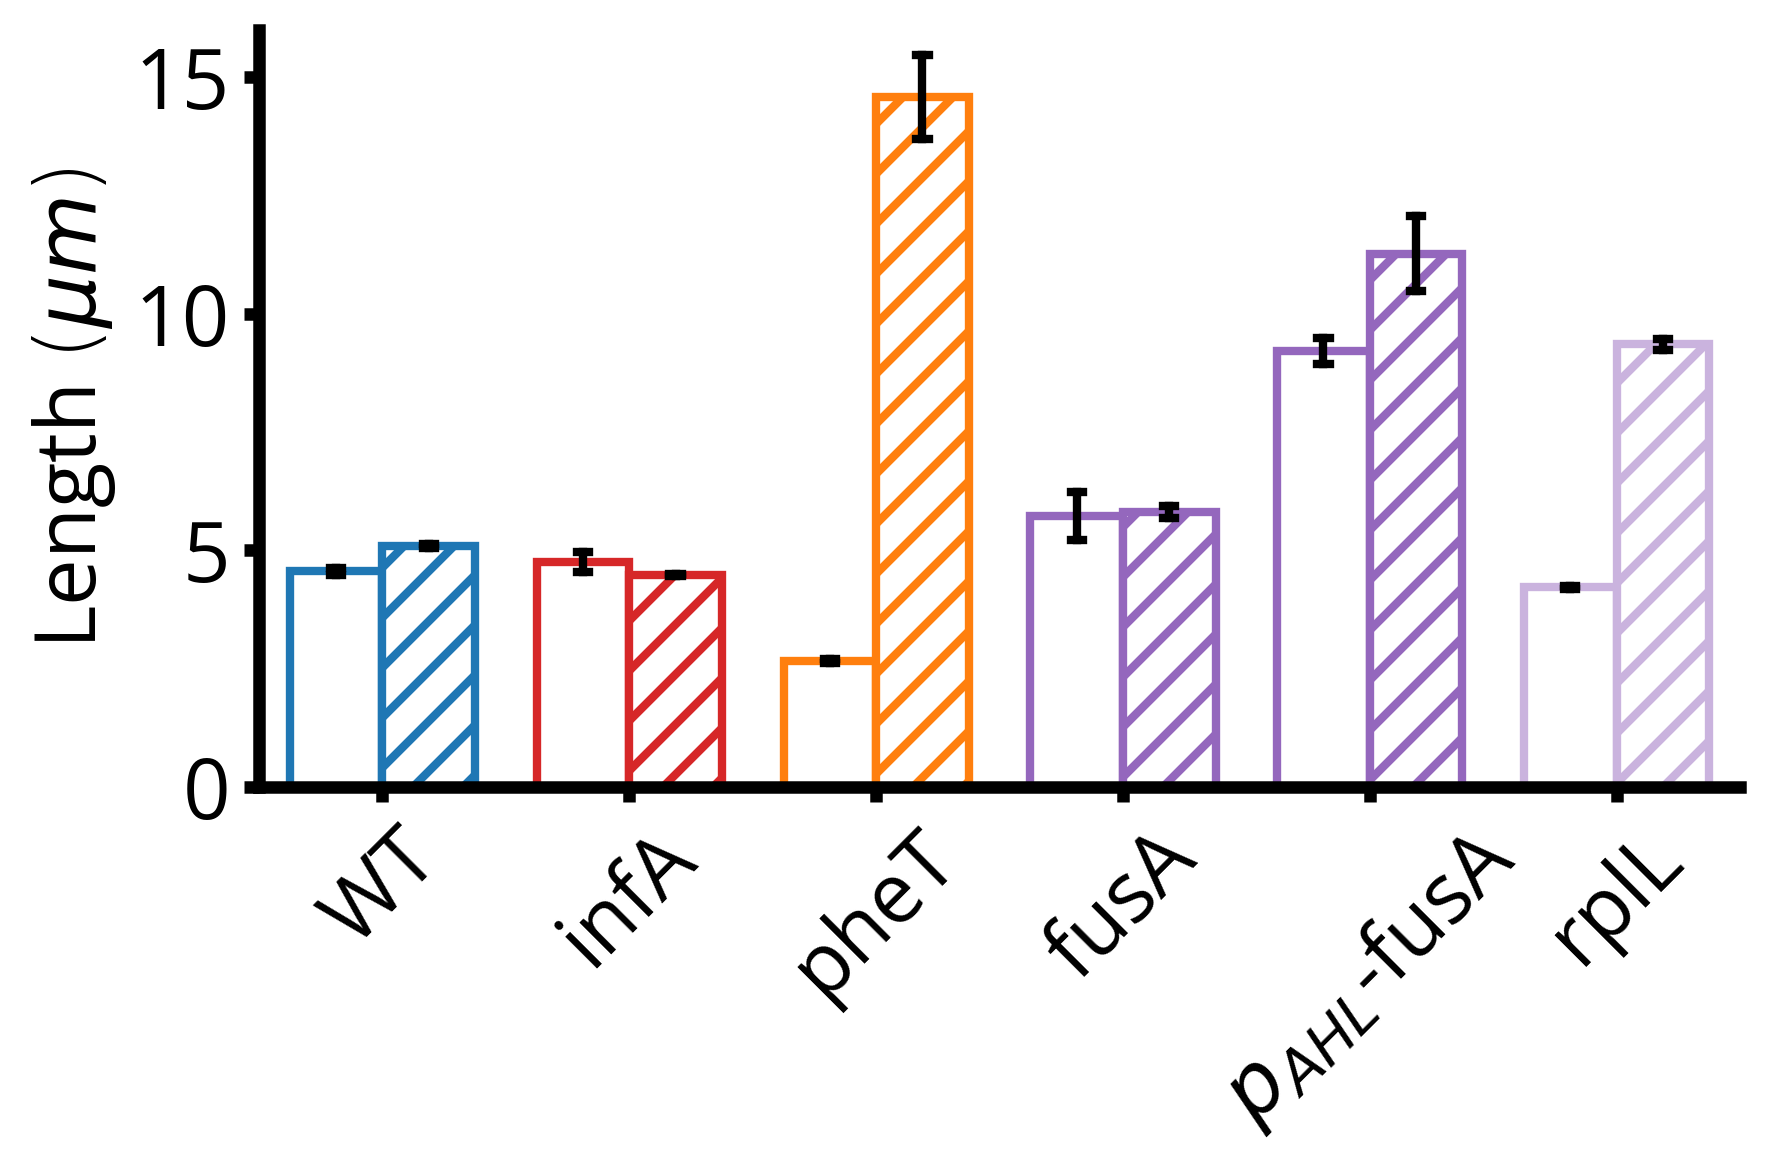

In [13]:
fig = plt.figure(figsize=(6,4))
hatch_thickness = 2

mpl.rcParams['hatch.linewidth'] = hatch_thickness

ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="major_axis_length",hue="relA",errorbar=("se",2),
                 order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")
# Apply custom colors to the bars
color_list = [strain_pallette[strain] for strain in strain_order]
custom_colors = color_list + color_list
for i,zipped in enumerate(zip(ax.patches, custom_colors)):
    bar, color = zipped
    bar.set_color("white")
    bar.set_edgecolor(color)
    if i>=len(color_list):
        bar.set_hatch('//')

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.xlabel("")

plt.tick_params(axis='x',rotation=45, labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size
plt.yticks([0,5,10,15])
plt.ylabel(r"Length $ (\mu m) $",fontsize=20)
lgd = plt.legend(fontsize=14) # You can set the fontsize for legend labels here
lgd.remove()
# lgd.set_title('Background', prop={'size': 14})
sns.despine(top=True,right=True)
plt.ylim(0,16)
# plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/Length_Plot_Set_2.png",transparent=True,dpi=500,bbox_inches="tight")

/tmp/ipykernel_11614/3013311208.py:11: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="Nucleoid Area Ratio",hue="relA",errorbar=("se",2),
/tmp/ipykernel_11614/3013311208.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="Nucleoid Area Ratio",hue="relA",errorbar=("se",2),


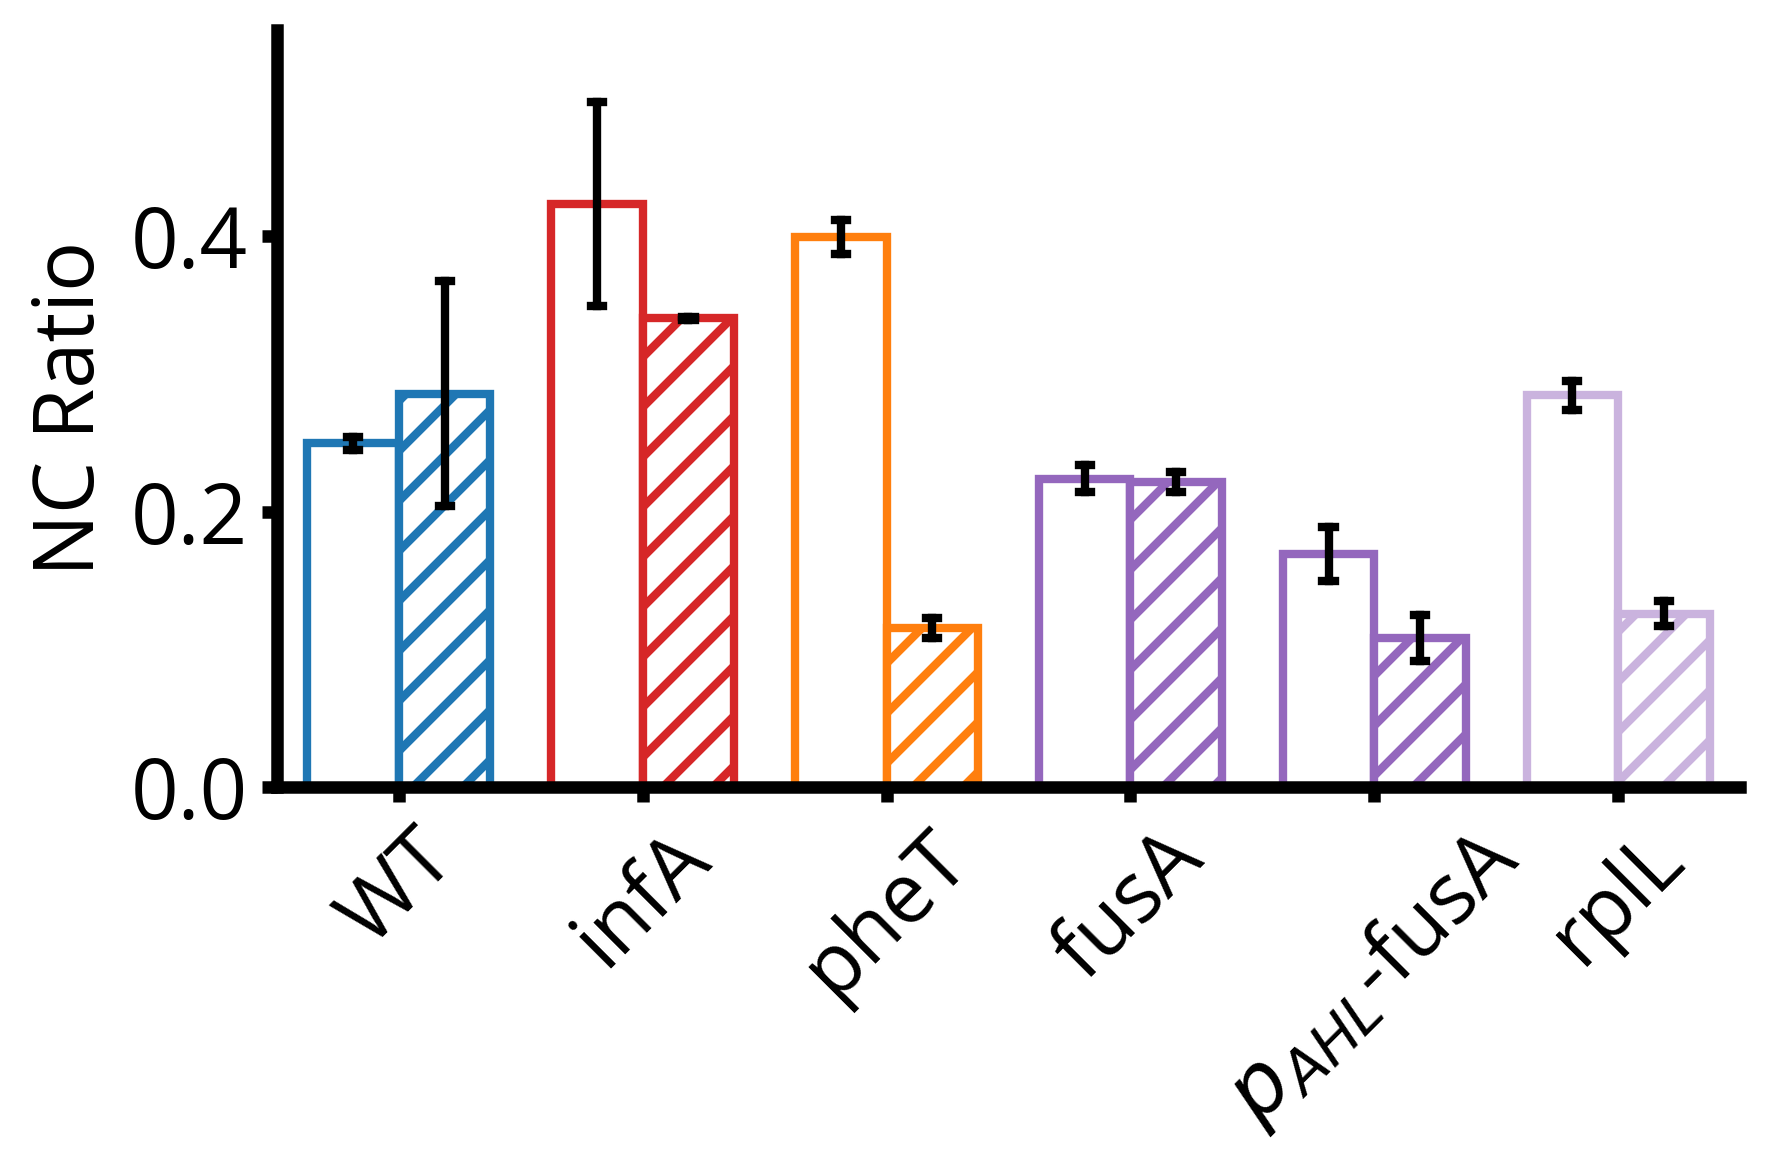

In [15]:
fig = plt.figure(figsize=(6,4))
hatch_thickness = 2

mpl.rcParams['hatch.linewidth'] = hatch_thickness

### barplot with 2x standard error error bars
# sem_frame = mean_df_subset.groupby(["Strain Name","relA"])["major_axis_length"].sem().to_frame()
# sem_arr = np.array(sem_frame.reset_index().set_index(["relA","Strain Name"]).loc["-"].loc[strain_order].values[:,0].tolist()+\
# sem_frame.reset_index().set_index(["relA","Strain Name"]).loc["+"].loc[strain_order].values[:,0].tolist())

ax = sns.barplot(data=mean_df_subset.reset_index(),x="Strain Name",y="Nucleoid Area Ratio",hue="relA",errorbar=("se",2),
                 order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")

# Apply custom colors to the bars
color_list = [strain_pallette[strain] for strain in strain_order]
custom_colors = color_list + color_list
for i,zipped in enumerate(zip(ax.patches, custom_colors)):
    bar, color = zipped
    bar.set_color("white")
    bar.set_edgecolor(color)
    if i>=len(color_list):
        bar.set_hatch('//')

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# wt_length = mean_df_subset.loc["WT","0"]["major_axis_length"].mean()
# ax.hlines(wt_length,-0.5,8.7,color="black",linestyles="--",alpha=0.5)

plt.ylim(0,0.55)
plt.tick_params(axis='x',rotation=45, labelsize=20, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=20, width=3)  # Set x-tick label size
plt.xlabel("")
plt.ylabel(r"NC Ratio",fontsize=20)
lgd = plt.legend(fontsize=14) # You can set the fontsize for legend labels here
lgd.remove()
# lgd.set_title('Background', prop={'size': 14})
sns.despine(top=True,right=True)
# plt.ylim(0.25,0.35)
# plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/DAPI_NA_Plot_Set_2.png",transparent=True,dpi=500,bbox_inches="tight")

### Select DAPI Images

In [215]:
plt.style.use('default')
scale_bar_size_um = 4

scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 390  # Y-position of the scale bar in data units
scalebar_x_position = 350  # X-position of the scale bar in data units
scalebar_on = False
genename_on = True

strain_name_map = {787:('WT','+'), 825:('WT','-'), 747:('tufA','+'), 824:('tufA','-'),
                   814:('rplL','+'), 818:('rplL','-'), 816:('infA','+'),820:('infA','-'),
                   817:('pheT','+'), 821:('pheT','-'), 815:('fusA','+'),819:('fusA','-'),
                   822:('P21::fusA','+'), 823:('P21::fusA','-'), 806:('pAHL-fusA','+'),808:('pAHL-fusA','-')}

strain_name_map_inv = {val:key for key,val in strain_name_map.items()}
pixel_microns = 0.0425
scale_bar_size_pixels = scale_bar_size_um//pixel_microns

In [216]:
selected_gene = "pAHL-fusA"
relA = "-"
run = 1
cell_idx = 3

sel_df = cell_df_with_nucleoid[(cell_df_with_nucleoid["Strain"] == strain_name_map_inv[(selected_gene,relA)])&(cell_df_with_nucleoid["Run"]==run)]
cell_per_fov = sel_df.groupby("fov").size()
max_cell_fov = cell_per_fov.index[np.argmax(cell_per_fov)]
high_density_sel_df = sel_df[sel_df["fov"]==max_cell_fov]
# sel_cell = sel_df.iloc[cell_idx]
sel_cell = high_density_sel_df.iloc[cell_idx]
centroid_y_pixels = int(sel_cell["centroid_y"]/pixel_microns)
centroid_x_pixels = int(sel_cell["centroid_x"]/pixel_microns)

In [218]:
diag_extent = 20

min_intensity_blue = 0
max_intensity_blue = 60000

min_intensity_grey = 0
max_intensity_grey = 30000

output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S5/Agar_Pads"

diag_extent_pixels = int(diag_extent/pixel_microns)
with h5py.File("/home/de64/scratch/de64/sync_folder/2023-10-08_DNA_RNA_Strain_Set_2_All_Rounds/hdf5/hdf5_" + str(sel_cell["File Index"]) + ".hdf5","r") as infile:
    nuc_data = infile["BFP-Penta"][0,centroid_y_pixels-(diag_extent_pixels//2):centroid_y_pixels+(diag_extent_pixels//2),\
                                         centroid_x_pixels-(diag_extent_pixels//2):centroid_x_pixels+(diag_extent_pixels//2)]
    phase_data = infile["MicroManager-Phase"][0,centroid_y_pixels-(diag_extent_pixels//2):centroid_y_pixels+(diag_extent_pixels//2),\
                                         centroid_x_pixels-(diag_extent_pixels//2):centroid_x_pixels+(diag_extent_pixels//2)]

merged_image = get_blue_grey_overlay(nuc_data,phase_data,min_intensity_blue,max_intensity_blue,\
                                       min_intensity_grey,max_intensity_grey)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
if genename_on:
    plt.text(10,
            10,
            f"{selected_gene}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=50)
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=10)
    # Add a label next to the scale bar
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+20,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=25)
    
plt.axis('off')

plt.savefig(output_path + "/" + selected_gene + "_" + str(relA) + "_" + str(cell_idx) + ".png",dpi=500,bbox_inches='tight')

In [237]:
plt.style.use('./deaton.mplstyle')